In [1]:
import geopandas as gpd
import pickle
import pandas as pd

from probe_lm import data_utils
from probe_lm import compute_erasure_terms, compute_metrics
import probe_lm

%load_ext autoreload
%autoreload 2

In [2]:
countries = gpd.read_file(
               gpd.datasets.get_path("naturalearth_lowres"))
countries = countries[(countries.name != "Antarctica") & (countries.name != "Fr. S. Antarctic Lands")]  # exclude 2 no-man lands


/var/folders/n9/fv7n0s8d3657l4gc0yjswvhm0000gr/T/ipykernel_4789/483856659.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  gpd.datasets.get_path("naturalearth_lowres"))


In [3]:
# load predictions
with open('../results_disambiguated/geography_aggregated_predictions_gpt-neox-20b.p', 'rb') as file:
    aggregated_predictions_gptneox = pickle.load(file) # already normalised

# alternatively: we could plot erasure bias rather than predictions
# load ground truth
ground_truth_file = "../data/english-speaking-population-data.txt"
ground_truth_raw = data_utils.read_population_data(ground_truth_file)
ground_truth = probe_lm.normalize_dict(ground_truth_raw)



In [4]:
# countries in the prediction data
prediction_countries = list(aggregated_predictions_gptneox.keys())

In [5]:
# countries in geopanda map
geopandas_countries = countries.name.values

In [6]:
print(len(prediction_countries), len(geopandas_countries))

127 175


In [7]:
# many of them already are the same -- nice! 
len(set(prediction_countries).intersection(set(geopandas_countries)))

90

In [8]:
# unmatched countries (in predictions but not in geopandas), before adjustment
unmatched_countries_predictions = set(prediction_countries).difference(set(geopandas_countries))
len(unmatched_countries_predictions)

37

### Semi-manually match countries

In [9]:
predictions_adjusted = aggregated_predictions_gptneox.copy()

# remove 'the'
country_names = list(predictions_adjusted.keys()).copy()
for country_name in country_names:
    if country_name.startswith('the'):
        country_name_new = ' '.join(country_name.split(' ')[1:])
        predictions_adjusted[country_name_new] = predictions_adjusted[country_name]
        del predictions_adjusted[country_name]

# manual renaming
predictions_adjusted['Solomon Is.'] = predictions_adjusted['Solomon Islands'] 
del predictions_adjusted['Solomon Islands'] 

predictions_adjusted['United States of America'] = predictions_adjusted['United States'] 
del predictions_adjusted['United States'] 


### Same for the erasure terms dict

In [10]:
# compute erasure bias terms for plotting
erasure_terms_dict = compute_erasure_terms(aggregated_predictions_gptneox, ground_truth, r=3) 
erasure_terms_adjusted = erasure_terms_dict.copy()

# remove 'the'
country_names = list(erasure_terms_dict.keys()).copy()
for country_name in country_names:
    if country_name.startswith('the'):
        country_name_new = ' '.join(country_name.split(' ')[1:])
        erasure_terms_adjusted[country_name_new] = erasure_terms_adjusted[country_name]
        del erasure_terms_adjusted[country_name]

# manual renaming
erasure_terms_adjusted['Solomon Is.'] = erasure_terms_adjusted['Solomon Islands'] 
del erasure_terms_adjusted['Solomon Islands'] 

erasure_terms_adjusted['United States of America'] = erasure_terms_adjusted['United States'] 
del erasure_terms_adjusted['United States'] 

### Same for ground truth (population data)

In [11]:
ground_truth_adjusted = ground_truth_raw.copy()

# remove 'the'
country_names = list(ground_truth_adjusted.keys()).copy()
for country_name in country_names:
    if country_name.startswith('the'):
        country_name_new = ' '.join(country_name.split(' ')[1:])
        ground_truth_adjusted[country_name_new] = ground_truth_adjusted[country_name]
        del ground_truth_adjusted[country_name]

# manual renaming
ground_truth_adjusted['Solomon Is.'] = ground_truth_adjusted['Solomon Islands'] 
del ground_truth_adjusted['Solomon Islands'] 

ground_truth_adjusted['United States of America'] = ground_truth_adjusted['United States'] 
del ground_truth_adjusted['United States'] 

In [12]:
# unmatched countries (in predictions but not in geopandas), after adjustment (37 before)
prediction_countries = list(ground_truth_adjusted.keys())
unmatched_countries_predictions = set(prediction_countries).difference(set(geopandas_countries))
len(unmatched_countries_predictions)

33

In [13]:
# unmatched countries (in predictions but not in geopandas), after adjustment (37 before)
prediction_countries = list(predictions_adjusted.keys())
unmatched_countries_predictions = set(prediction_countries).difference(set(geopandas_countries))
len(unmatched_countries_predictions)

33

In [14]:
# same for erasure terms
prediction_countries = list(erasure_terms_adjusted.keys())
unmatched_countries_predictions = set(prediction_countries).difference(set(geopandas_countries))
len(unmatched_countries_predictions)

33

In [15]:
# unmatched countries (in predictions but not in geopandas)
unmatched_countries_geopandas = set(geopandas_countries).difference(set(prediction_countries))
len(unmatched_countries_geopandas)

81

In [16]:
countries.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [17]:
countries['prediction'] = None
countries['erasure'] = None

In [18]:
for i, row in countries.iterrows():
    country_name = row['name']
    if country_name in prediction_countries:
        countries.loc[i, 'prediction'] = predictions_adjusted[country_name]
        countries.loc[i, 'erasure'] = erasure_terms_adjusted[country_name]
        countries.loc[i, 'population'] = ground_truth_adjusted[country_name] / 1e6

In [19]:
countries.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,prediction,erasure,population
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",0.000965,0,0.176000
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",0.002521,0,4.000000
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",None,None,NaN
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",0.037154,0,30.480750
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",0.155517,0,316.107532


In [20]:
countries['prediction'] = countries['prediction'].astype(float)
countries['erasure'] = countries['erasure'].astype(float)
countries['population'] = countries['population'].astype(float)

### Go through unmacthed countries manually and match them

In [21]:
list(unmatched_countries_predictions)[20:]

['Andorra',
 'Malta',
 'Kiribati',
 'Cook Islands',
 'Saint Kitts and Nevis',
 'Grenada',
 'Seychelles',
 'Tonga',
 'Mauritius',
 'Anguilla',
 'U.S. Virgin Islands',
 'Palau',
 'Saint Vincent and the Grenadines']

In [22]:
letter = 'I'

In [23]:
print([c for c in unmatched_countries_predictions if c.startswith(letter)])

['Isle of Man']


In [24]:
print([c for c in unmatched_countries_geopandas if c.startswith(letter)])

['Iceland', 'Indonesia', 'Iran']


In [25]:
list(unmatched_countries_predictions)[20:]

['Andorra',
 'Malta',
 'Kiribati',
 'Cook Islands',
 'Saint Kitts and Nevis',
 'Grenada',
 'Seychelles',
 'Tonga',
 'Mauritius',
 'Anguilla',
 'U.S. Virgin Islands',
 'Palau',
 'Saint Vincent and the Grenadines']

In [26]:
[c for c in unmatched_countries_geopandas if c.startswith('S')]

['South Korea',
 'Serbia',
 'Syria',
 'Somaliland',
 'Sudan',
 'Somalia',
 'S. Sudan',
 'Senegal',
 'Saudi Arabia']

### Plot world map based on prediction data

None


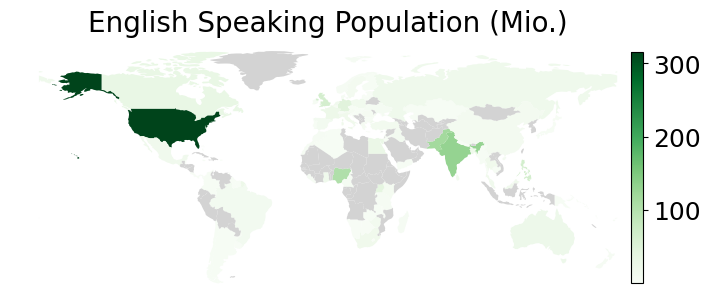

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, figsize=(8, 8))

ax = countries.plot(
        column='population',  
        cmap='Greens', 
        missing_kwds={"color": "lightgrey"}, 
        legend=True,
        legend_kwds={'shrink': 0.3, "orientation": "vertical", "pad": -0.02}, # 'prop':18},
        ax=ax)
plt.tight_layout()
ax.set_title("English Speaking Population (Mio.)", fontsize=20)
ax.axis('off')
leg = ax.get_legend()
print(leg)

# complicated way to extract the legend
fig = ax.figure
leg = fig.axes[1]
leg.tick_params(labelsize=18)

plt.savefig('images/teaser/model_population_worldmap.pdf',bbox_inches='tight', pad_inches=0.01)

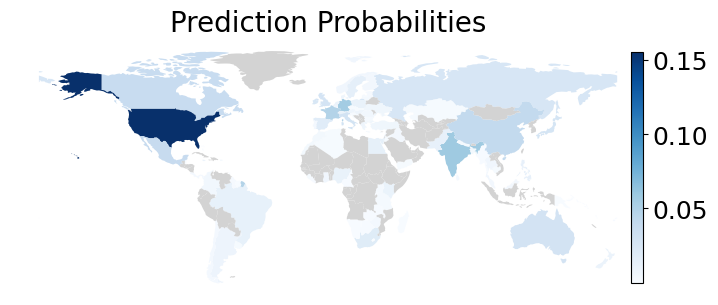

In [28]:
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set_theme()


fig, ax = plt.subplots(1, figsize=(8, 8))

countries.plot(
        column='prediction',  
        cmap='Blues', 
        missing_kwds={"color": "lightgrey"}, 
        legend=True,
        legend_kwds={'shrink': 0.3, "orientation": "vertical", "pad": -0.02},
        ax=ax)
plt.tight_layout()
ax.set_title("Prediction Probabilities", fontsize=20)
ax.axis('off')

# complicated way to extract the legend
fig = ax.figure
leg = fig.axes[1]
leg.tick_params(labelsize=18)


plt.savefig('images/teaser/model_pred_worldmap.pdf',bbox_inches='tight', pad_inches=0.01)

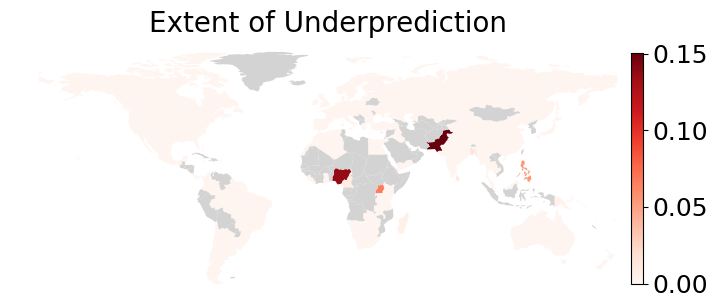

In [119]:
fig, ax = plt.subplots(1, figsize=(8, 8))

countries.plot(
        column='erasure',  
        cmap='Reds', # 'OrRd', 
        missing_kwds={"color": "lightgrey"}, 
        legend=True,
        legend_kwds={'shrink': 0.3, "orientation": "vertical", "pad": -0.02},
        ax=ax)
ax.set_title("Extent of Underprediction", fontsize=20)
plt.tight_layout()
ax.axis('off')

# complicated way to extract the legend
fig = ax.figure
leg = fig.axes[1]
leg.tick_params(labelsize=18)

plt.savefig('images/teaser/erasure_worldmap.pdf',bbox_inches='tight', pad_inches=0.01)